# Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install transformers

In [ ]:
import numpy as np
import pandas as pd
from math import ceil, floor
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.layers as L
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.model_selection import train_test_split
from transformers import BertConfig, TFBertPreTrainedModel, TFBertMainLayer
from transformers import RobertaConfig, TFRobertaPreTrainedModel, TFRobertaMainLayer, TFRobertaModel
from tokenizers import BertWordPieceTokenizer, ByteLevelBPETokenizer
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import os

import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#read data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/6000/tweet-sentiment-extraction/train.csv', header = 0).dropna()

In [ ]:
train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
def jaccard(str1, str2): 
    a = set(str(str1).lower().split()) 
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Data Preprocessing

In [ ]:
Y = train['selected_text']
X = train.drop(columns=['selected_text'])
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=1)

In [ ]:
Y_train = pd.DataFrame(Y_train)
train = X_train.join(Y_train)
test = X_test.copy()
Y_test = pd.DataFrame(Y_test)
sample = X_test.join(Y_test)

In [ ]:
index1 = pd.DataFrame([i for i in range(train.shape[0])])
train.set_index(index1[0],inplace= True)

In [ ]:
index2 = pd.DataFrame([i for i in range(test.shape[0])])
test.set_index(index2[0],inplace= True)

In [ ]:
index3 = pd.DataFrame([i for i in range(sample.shape[0])])
sample.set_index(index3[0],inplace= True)

In [ ]:
train

,textID,text,sentiment,selected_text
0,,,,
0,1376de5329,Just Finished My English Final...Just One Step...,neutral,Just Finished My English Final...Just One Step...
1,aac1cc6fd4,Also with the not driving part i could afford ...,positive,save ev
2,9672b4ee61,GREEN DAY IS PERFORMING ON SNL NEXT WEEK! sor...,neutral,"sorry, that made me happy and i`m still all di..."
3,44e7f97625,I am never going to get these pictures taken,neutral,I am never going to get these pictures taken
4,ab1368e993,why thank you. Couldn`t resist it,neutral,why thank you. Couldn`t resist it
...,...,...,...,...
21979,fcc45b5d05,_girl - Bummer...mail came but package didn`t,negative,Bummer..
21980,62ae10ec84,My trip to Igbaras will be postponed to next week,neutral,My trip to Igbaras will be postponed to next week
21981,66ab9d1f77,"Just an observation: Aside from the riverwalk,...",neutral,"Just an observation: Aside from the riverwalk,..."


In [ ]:
test

,textID,text,sentiment
0,,,
0,50726f1adb,smH daTs whacK,neutral
1,8a87bf47ff,"oh dear, thats not good - I hope you get thro...",neutral
2,f90dccdae7,"this hole twitter thing is new too me, its not...",negative
3,884476afed,"@_elj Appreciated,uni email is helpful..",positive
4,1f27adbaa5,", Just read an article that buying IP`s doesn...",neutral
...,...,...,...
5491,b5e3b51d4c,"MC, happy mother`s day to your mom ;).. love yah",positive
5492,7bb003fcac,Glad you are happy!,positive
5493,5f4484b1e4,mcfly anit been on here in ages z,neutral


#training

In [ ]:
MAX_SEQUENCE_LEN = 96
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab='/content/drive/My Drive/Colab Notebooks/6000/vocab-roberta-base.json', 
    merges='/content/drive/My Drive/Colab Notebooks/6000/merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}


In [ ]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_SEQUENCE_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_SEQUENCE_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_SEQUENCE_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_SEQUENCE_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_SEQUENCE_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

In [ ]:
ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_SEQUENCE_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_SEQUENCE_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_SEQUENCE_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

In [ ]:
def build_model():
    ids = tf.keras.layers.Input((MAX_SEQUENCE_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_SEQUENCE_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_SEQUENCE_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained('/content/drive/My Drive/Colab Notebooks/6000/config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained('/content/drive/My Drive/Colab Notebooks/6000/pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

#Prediction&Evaluation

In [ ]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_SEQUENCE_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_SEQUENCE_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_SEQUENCE_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_SEQUENCE_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
    
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/6000/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
550/550 [==============================] - ETA: 0s - loss: 2.2612 - activation_loss: 1.0978 - activation_1_loss: 1.1633
Epoch 00001: val_loss improved from inf to 1.65200, saving model to v0-roberta-0.h5
550/550 [==============================] - 227s 413ms/step - loss: 2.2612 - activation_loss: 1.0978 - activation_1_loss: 1.1633 - val_loss: 1.6520 - val_activation_loss: 0.8589 - val_activation_1_loss: 0.7931
Epoch 2/3
550/550 [==============================] - ETA: 0s - loss: 1.6629 - activation_loss: 0.8479 - activation_1_loss: 0.8149
Epoch 00002: val_loss improved from 1.65200 to 1.60862, saving model to v0-roberta-0.h5
550/550 [==============================] - 226s 411ms/step - loss: 1.6629 - activation_loss: 0.8479 - activation_1_loss: 0.8149 - val_loss: 1.6086 - val_activation_loss: 0.8453 - val_activation_1_loss: 0.7633
Epoch 3/3
550/550 [==============================] - ETA: 0s - loss: 1.5010 - activation_loss: 0.7710 - activation_1_loss: 0.7300
Epoch 00003: val_los

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/6000/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
550/550 [==============================] - ETA: 0s - loss: 2.2810 - activation_loss: 1.1283 - activation_1_loss: 1.1527
Epoch 00001: val_loss improved from inf to 1.67846, saving model to v0-roberta-1.h5
550/550 [==============================] - 227s 413ms/step - loss: 2.2810 - activation_loss: 1.1283 - activation_1_loss: 1.1527 - val_loss: 1.6785 - val_activation_loss: 0.8573 - val_activation_1_loss: 0.8211
Epoch 2/3
550/550 [==============================] - ETA: 0s - loss: 1.8542 - activation_loss: 0.9024 - activation_1_loss: 0.9518
Epoch 00002: val_loss did not improve from 1.67846
550/550 [==============================] - 224s 407ms/step - loss: 1.8542 - activation_loss: 0.9024 - activation_1_loss: 0.9518 - val_loss: 2.5867 - val_activation_loss: 1.0236 - val_activation_1_loss: 1.5631
Epoch 3/3
550/550 [==============================] - ETA: 0s - loss: 1.7761 - activation_loss: 0.8755 - activation_1_loss: 0.9006
Epoch 00003: val_loss improved from 1.67846 to 1.65654, s

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/6000/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
550/550 [==============================] - ETA: 0s - loss: 2.5284 - activation_loss: 1.2220 - activation_1_loss: 1.3065
Epoch 00001: val_loss improved from inf to 1.78828, saving model to v0-roberta-2.h5
550/550 [==============================] - 227s 413ms/step - loss: 2.5284 - activation_loss: 1.2220 - activation_1_loss: 1.3065 - val_loss: 1.7883 - val_activation_loss: 0.8783 - val_activation_1_loss: 0.9100
Epoch 2/3
550/550 [==============================] - ETA: 0s - loss: 1.7288 - activation_loss: 0.8750 - activation_1_loss: 0.8538
Epoch 00002: val_loss improved from 1.78828 to 1.65549, saving model to v0-roberta-2.h5
550/550 [==============================] - 225s 409ms/step - loss: 1.7288 - activation_loss: 0.8750 - activation_1_loss: 0.8538 - val_loss: 1.6555 - val_activation_loss: 0.8505 - val_activation_1_loss: 0.8050
Epoch 3/3
550/550 [==============================] - ETA: 0s - loss: 1.5843 - activation_loss: 0.7983 - activation_1_loss: 0.7860
Epoch 00003: val_los

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/6000/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
550/550 [==============================] - ETA: 0s - loss: 2.2276 - activation_loss: 1.1061 - activation_1_loss: 1.1215
Epoch 00001: val_loss improved from inf to 1.68816, saving model to v0-roberta-3.h5
550/550 [==============================] - 228s 415ms/step - loss: 2.2276 - activation_loss: 1.1061 - activation_1_loss: 1.1215 - val_loss: 1.6882 - val_activation_loss: 0.8554 - val_activation_1_loss: 0.8327
Epoch 2/3
550/550 [==============================] - ETA: 0s - loss: 1.6790 - activation_loss: 0.8605 - activation_1_loss: 0.8184
Epoch 00002: val_loss improved from 1.68816 to 1.66411, saving model to v0-roberta-3.h5
550/550 [==============================] - 225s 410ms/step - loss: 1.6790 - activation_loss: 0.8605 - activation_1_loss: 0.8184 - val_loss: 1.6641 - val_activation_loss: 0.8254 - val_activation_1_loss: 0.8387
Epoch 3/3
550/550 [==============================] - ETA: 0s - loss: 1.5110 - activation_loss: 0.7773 - activation_1_loss: 0.7338
Epoch 00003: val_los

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/6000/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
550/550 [==============================] - ETA: 0s - loss: 2.1796 - activation_loss: 1.0833 - activation_1_loss: 1.0963
Epoch 00001: val_loss improved from inf to 1.70535, saving model to v0-roberta-4.h5
550/550 [==============================] - 228s 414ms/step - loss: 2.1796 - activation_loss: 1.0833 - activation_1_loss: 1.0963 - val_loss: 1.7053 - val_activation_loss: 0.8696 - val_activation_1_loss: 0.8357
Epoch 2/3
550/550 [==============================] - ETA: 0s - loss: 1.6344 - activation_loss: 0.8382 - activation_1_loss: 0.7961
Epoch 00002: val_loss improved from 1.70535 to 1.67590, saving model to v0-roberta-4.h5
550/550 [==============================] - 226s 410ms/step - loss: 1.6344 - activation_loss: 0.8382 - activation_1_loss: 0.7961 - val_loss: 1.6759 - val_activation_loss: 0.8493 - val_activation_1_loss: 0.8266
Epoch 3/3
550/550 [==============================] - ETA: 0s - loss: 1.4678 - activation_loss: 0.7585 - activation_1_loss: 0.7093
Epoch 00003: val_los

In [ ]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

>>>> OVERALL 5Fold CV Jaccard = 0.7051530928414108


In [ ]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [ ]:
test['selected_text'] = all

In [ ]:
r = pd.DataFrame(test.copy()['selected_text'])
g = pd.DataFrame(sample.copy()['selected_text'])
g.rename(columns = {'selected_text':'groud_truth'},inplace = True)
result = r.join(g)

In [ ]:
score = []

for ind,row in result.iterrows():
    sentence1 = row.groud_truth
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    score.append([sentence1,sentence2,jaccard_score])

In [ ]:
result = pd.DataFrame(score,columns=["groud_truth","selected_text","jaccard_score"])

In [ ]:
result

,groud_truth,selected_text,jaccard_score
0,smH daTs whacK,smh dats whack,1.000000
1,"oh dear, thats not good - I hope you get throu...","oh dear, thats not good - i hope you get thro...",1.000000
2,stuvk with the wee stpid thing fo,its not letting me change my picture so your ...,0.062500
3,uni email is helpful..,"appreciated,uni email is helpful..",0.600000
4,", Just read an article that buying IP`s doesn`...",", just read an article that buying ip`s doesn...",0.944444
...,...,...,...
5491,"MC, happy mother`s day to your mom ;).. love yah",happy,0.100000
5492,Glad you are happy!,glad you are happy!,1.000000
5493,mcfly anit been on here in ages z,mcfly anit been on here in ages z,1.000000
5494,that`s not good to hear! i hope everything is...,that`s not good to hear! i hope everything is...,0.409091


In [ ]:
result['jaccard_score'].mean()

0.7091341125706987

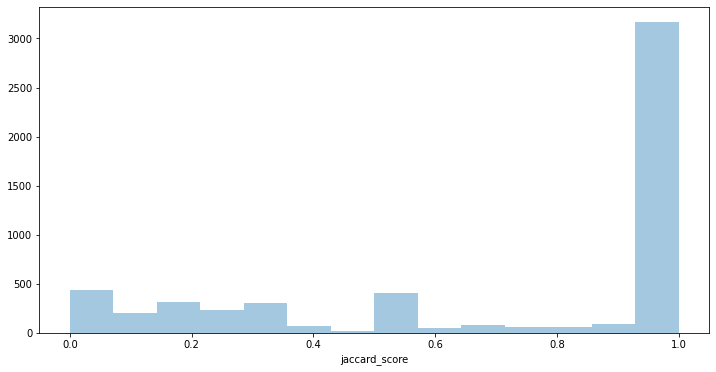

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.distplot(result['jaccard_score'],kde=False)